# Машинное обучение, ФКН ВШЭ
## Практическое задание 3.

Срок сдачи: 02.12.2023 14:40

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW1_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW1_IvanovII.ipynb*). Далее отправьте этот файл на bobrovskaya_op@surgu.ru или Smorodinov-1990@mail.ru.

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.base import BaseEstimator

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.35358678329454

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.942141493243643

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.3 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

Text(0.5, 1.0, 'trees')

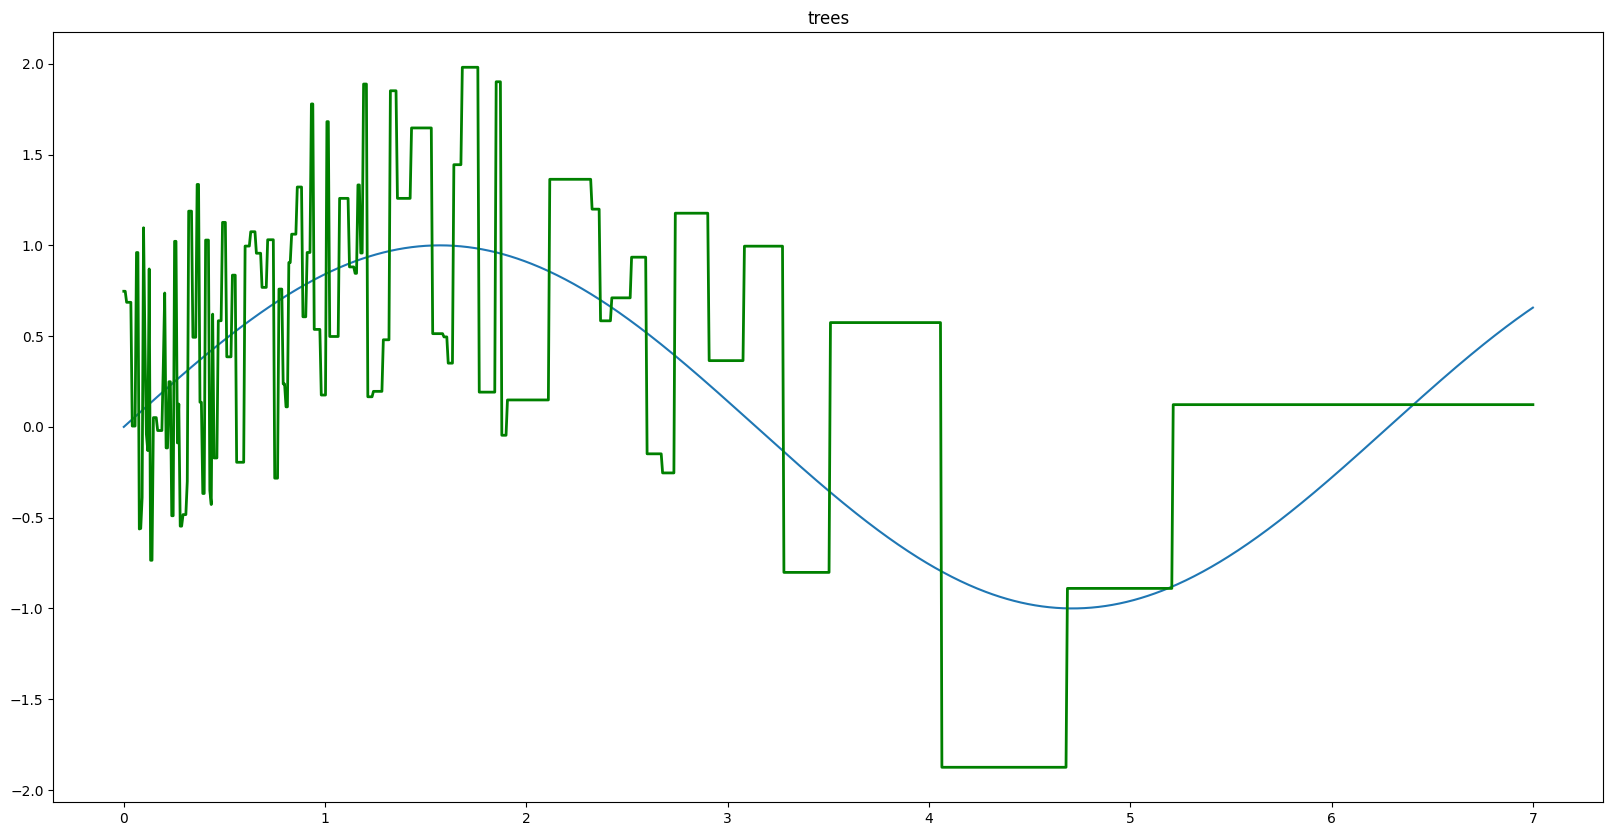

In [5]:
X = np.random.exponential(size=sample_size)
y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)

tr = DecisionTreeRegressor()
tr.fit(X[:, np.newaxis], y)

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(linspace, f(linspace))
plt.plot(linspace, tr.predict(linspace.reshape(-1, 1)), c='green', linewidth=2)
plt.title('trees')

__2 (0.3 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

Text(0.5, 1.0, 'trees')

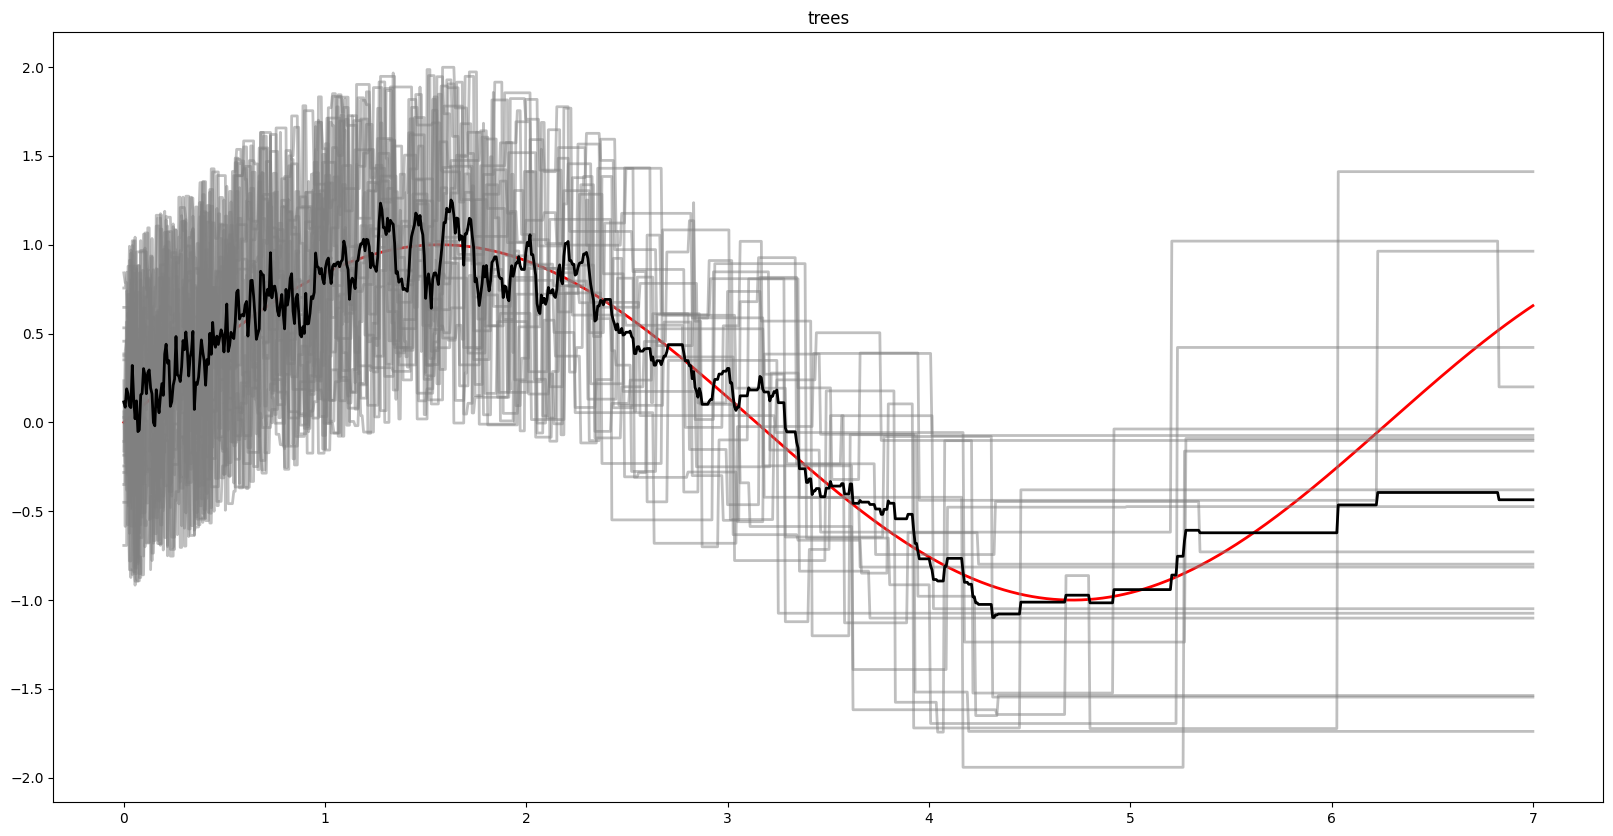

In [6]:
predictions = []
for i in range(samples_num):
    X = np.random.exponential(size=sample_size)
    y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
    tr = DecisionTreeRegressor()
    tr.fit(X[:, np.newaxis], y)
    predictions.append(tr.predict(linspace.reshape(-1, 1)))

fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(linspace, f(linspace), c='red', linewidth=2)
for pred in predictions:
    plt.plot(linspace, pred, c='gray', alpha=0.5, linewidth=2)
plt.plot(linspace, np.sum(np.array(predictions), axis=0) / samples_num, c='black', linewidth=2)

plt.title('trees')


__3 (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

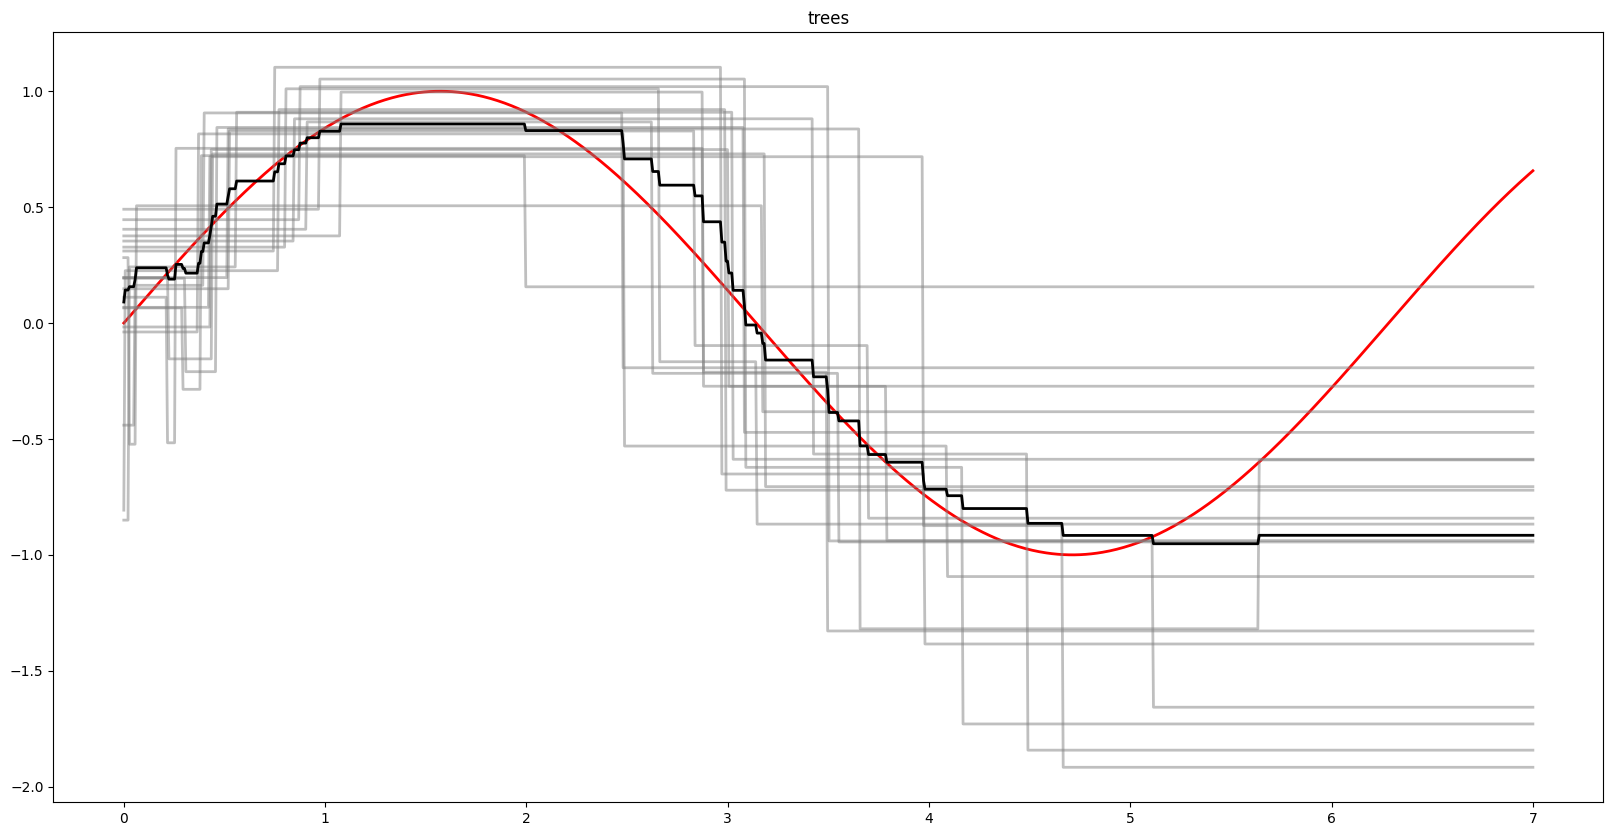

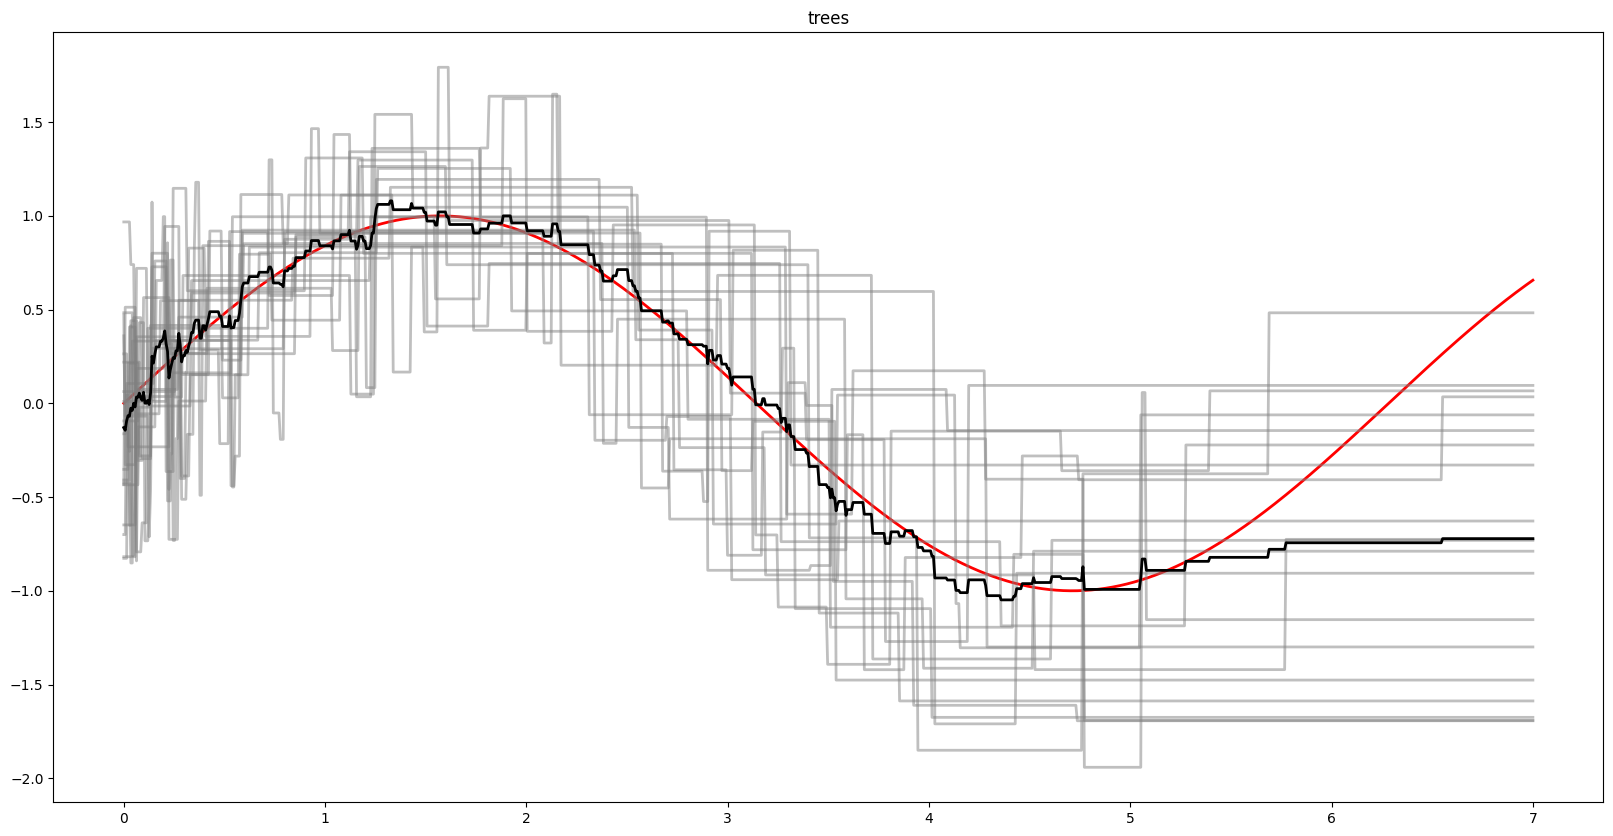

In [7]:
for depth in [2,4]:
    predictions = []
    for i in range(samples_num):
        X = np.random.exponential(size=sample_size)
        y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
        tr = DecisionTreeRegressor(max_depth=depth)
        tr.fit(X[:, np.newaxis], y)
        predictions.append(tr.predict(linspace.reshape(-1, 1)))

    fig, ax = plt.subplots(figsize=(20, 10))

    plt.plot(linspace, f(linspace), c='red', linewidth=2)
    for pred in predictions:
        plt.plot(linspace, pred, c='gray', alpha=0.5, linewidth=2)
    plt.plot(linspace, np.sum(np.array(predictions), axis=0) / samples_num, c='black', linewidth=2)

    plt.title('trees')


__4 (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

(・・ ) ?



#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте - это сумма значения истинной функции на объекте плюс шумовая компонента, также сгенерированная из некоторого распределения.

__4 (1 балл) __Реализуйте функцию:

In [8]:
def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform, noise_generator=np.random.uniform,
                          sample_size=100, samples_num=100, objects_num=50):
    X = x_generator(size=sample_size)
    y = dependence_fun(X)


    noise = noise_generator(size=sample_size)
    y_n = y + noise.mean()

    E_y_with_x = y + np.mean(noise, axis=0)
    
    mean_prediction = np.zeros(sample_size)
    for i in range(samples_num):
        X_sample = x_generator(size=sample_size)
        y_sample = dependence_fun(X_sample) + noise_generator(size=sample_size)
        tr = regressor()
        tr.fit(X_sample[:, np.newaxis], y_sample)
        mean_prediction += tr.predict(X[:, np.newaxis]) / samples_num

    bias = np.mean((y + noise - mean_prediction) ** 2, axis=0)

    var_prediction = np.zeros(sample_size)
    for i in range(samples_num):
        X_sample = x_generator(size=sample_size)
        y_sample = dependence_fun(X_sample) + noise_generator(size=sample_size)
        tr = regressor()
        tr.fit(X_sample[:, np.newaxis], y_sample)
        var_prediction += (tr.predict(X.reshape(-1, 1)) - mean_prediction) ** 2 / samples_num
    variance = np.mean(var_prediction, axis=0)
    return bias, variance

Параметры:
* regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor, LinearRegression, Lasso, RandomForestRegressor ...)
* dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор такой же длины. Примеры: np.sin, lambda x: x\*\*2.
* x_generator: функция, генерирующая одномерную выборку объектов и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* noise_generator: функция, генерирующая одномерную выборку шумовых компонент (по одной на каждый объект) и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* sample_size: число объектов в выборке.
* samples_num: число выборок, которые нужно сгенерировать, чтобы оценить интеграл по X
* objects_num: число объектов, которые нужно сгенерировать, чтобы оценить интеграл по x.

Вовращаемые значения:
* Смещение алгоритма regressor (число)
* Разброс алгоритма regressor (число)

_Рекомендации:_ 
* Создайте вектор объектов для оценивания интеграла по $x$, затем вектор правильных ответов на нем и вектор зашумленных правильных ответов. $\mathbb{E}[y|x]$ оценивается как сумма правильного ответа на объекте и мат. ожидания шума (который оценивается генерацией отдельной шумовой выборки длины objects_num и усреднением значений в ней). $\mathbb{E}_X [\mu(X)]$ оценивается как в предыдущей задаче: нужно обучить regressor на samples_num выборках длины sample_size и усреднить предсказания на сгенерированных ранее объектах. Смещение - это среднее квадрата разности вектора зашумленных ответов и вектора предсказаний. Для оценки разброса нужно еще раз сгенерировать samples_num выборок.
* Проверить правильность реализации можно на примерах, которые разбирались на семинаре и в домашней работе.

__5 (0.4 балла) Заполните таблицу.__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [9]:
compute_bias_variance(regressor=LinearRegression, dependence_fun=lambda x: x ** 2, noise_generator=lambda size: np.random.normal(0, 1, size=size), x_generator=lambda size: np.random.normal(0, 1, size=size), sample_size=1000)

(2.7393828359142556, 0.014291615320900066)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [11]:
regressors = [LinearRegression, 
              DecisionTreeRegressor, 
              RandomForestRegressor,
              GradientBoostingRegressor]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              np.random.uniform]

In [12]:
bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                      index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
variance = pd.DataFrame(columns=bias.columns, index=bias.index)

In [13]:
for idx_r, regressor in enumerate(regressors):
    for idx_g, generator in enumerate(generators):
        bias.iloc[idx_r, idx_g], variance.iloc[idx_r, idx_g] = compute_bias_variance(regressor=regressor, dependence_fun=lambda x:5 * np.sin(10 * x),
                                                                                x_generator=generator, noise_generator=generator)
        

In [14]:
bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.757874,9.552482,13.364072,11.950857
DecisionTree,0.156606,0.45205,0.409329,0.092219
RandomForest,0.19476,0.581595,0.409029,0.07831
GradientBoosting,0.178073,0.341931,0.363975,0.077973


In [15]:
variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.255499,0.483313,0.209188,0.192536
DecisionTree,0.322119,0.659065,0.640893,0.144475
RandomForest,0.260936,0.382125,0.331751,0.081854
GradientBoosting,0.36128,0.729156,0.477006,0.123058


__6 (0.6 балла) Проанализируйте полученные таблицы. Ответьте на вопросы:__
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

(・・ ) ?



__6* (0.5 доп. балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

### II. Композиции деревьев
#### Задача 3. Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [16]:
X = pd.read_csv('winequality-red.csv', sep=';')
y = X['quality']
X = X.drop(['quality'], axis=1)
X.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [17]:
DTC = DecisionTreeClassifier()
print("DTC", cross_val_score(DTC, X, y, scoring=make_scorer(accuracy_score)).mean())
BC = BaggingClassifier(n_estimators=100, n_jobs=-1)
print("BC", cross_val_score(BC, X, y, scoring=make_scorer(accuracy_score)).mean())
BC_half_feat = BaggingClassifier(n_estimators=100, n_jobs=-1, max_features=0.5)
print("BC_half_feat", cross_val_score(BC_half_feat, X, y, scoring=make_scorer(accuracy_score)).mean())
RFC = RandomForestClassifier(n_estimators=100, n_jobs=-1)
print("RFC", cross_val_score(RFC, X, y, scoring=make_scorer(accuracy_score)).mean())

DTC 0.470282131661442
BC 0.5691065830721003
BC_half_feat 0.5709815830721003
RFC 0.5697296238244514


#### Задача 4. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [18]:
X = pd.read_csv('winequality-red.csv', sep=';')
X = X.iloc[np.random.permutation(len(X))]
y = X['quality']
X = X.drop(['quality'], axis=1)
X.head(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [19]:
accuracy_scores = []
RF = RandomForestClassifier(warm_start=True, n_estimators=100, n_jobs=-1)
RF.fit(X_train, y_train)
accuracy_scores.append(accuracy_score(y_test, RF.predict(X_test)))
for n_est in range(110, 5001, 10):
    RF.set_params(n_estimators=n_est)
    RF.fit(X_train, y_train)
    accuracy_scores.append(accuracy_score(y_test, RF.predict(X_test)))

Text(0, 0.5, 'accuracy score')

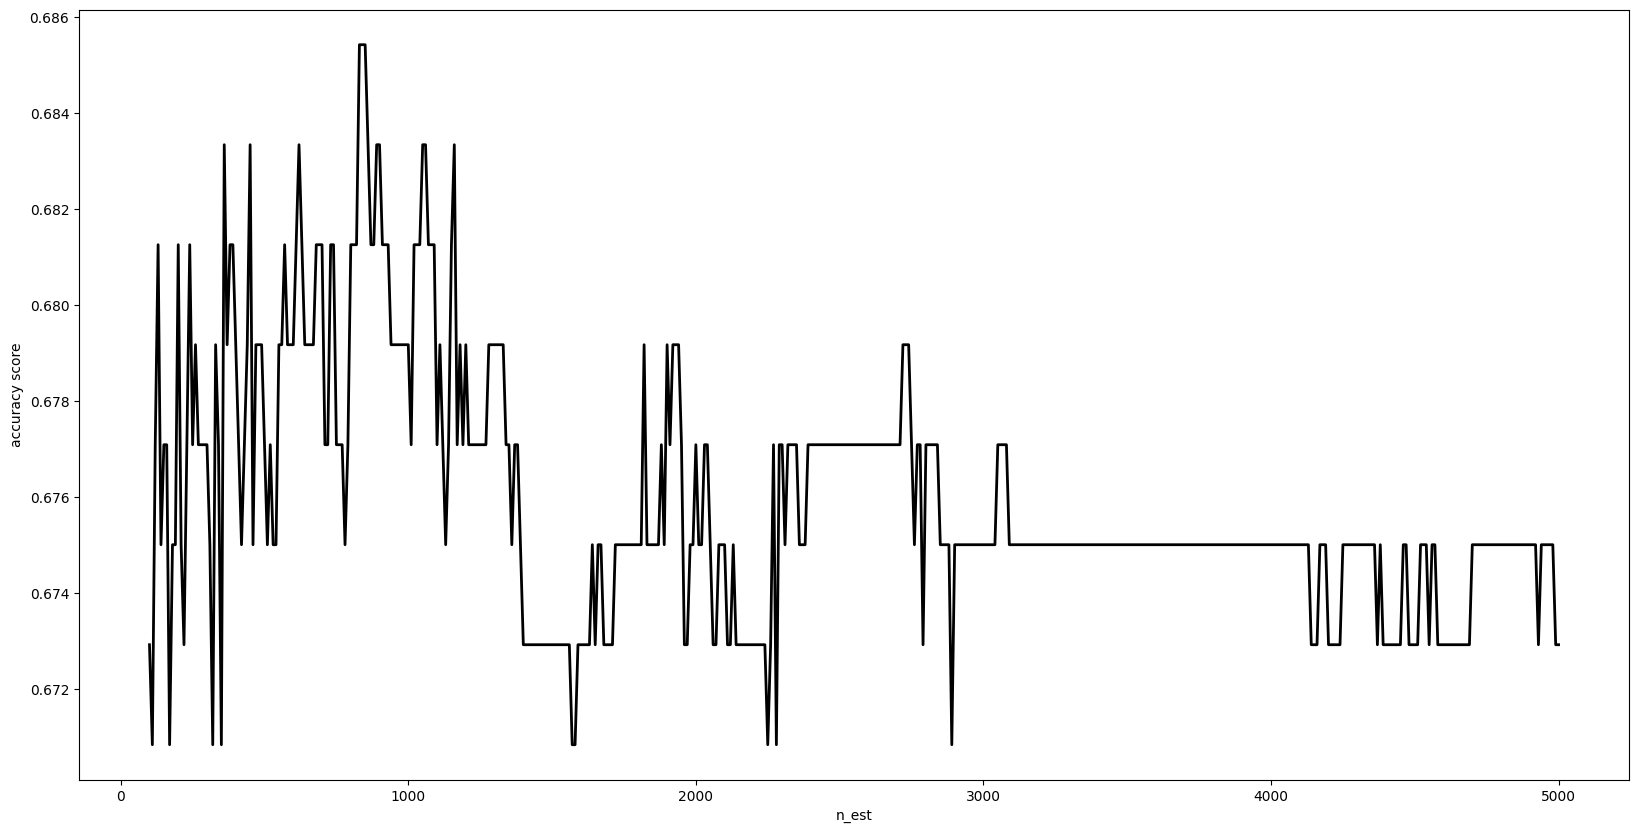

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot([n_est for n_est in range(100, 5001, 10)], accuracy_scores, c='black', linewidth=2)
plt.xlabel('n_est')
plt.ylabel('accuracy score')